<h1 style="font-family:Times New Roman;color:blue">Кластерный анализ, Prim's algorithm</h1>

*Nikolay Sitala 2021, nsitala@ukr.net*

<h3 style="font-family:Times New Roman;color:gray">Пример матрицы расстояний Excel .xlsx</h3>

In [8]:
import io
import base64
from openpyxl import load_workbook
from ipywidgets import HTML
from IPython.display import FileLink


def create_download_link_excel(output, title = "Скачайте пример матрицы расстояний в Excel .xlsx", filename = "matrix_dist.xlsx"): 

    excel_data = output.getvalue()
    b64 = base64.b64encode(excel_data)
    payload = b64.decode()
    
    html = '<a download="{filename}" href="data:text/xml;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


with open("matrix_dist_example.test", "rb") as f:
    btext = io.BytesIO(f.read())

create_download_link_excel(btext)   

HTML(value='<a download="matrix_dist.xlsx" href="data:text/xml;base64,UEsDBBQABgAIAAAAIQB8bJgWaQEAAKAFAAATAAgC…

1. Книга должна содержать 'Лист' с названием **'array'**
2. На листе не должно быть подписей для строк и столбцов

3. На листах **'data'** и **'array_example'** показаны отношения между адресами с указанием номеров вершин и расположения вершин в матрице расстояний   
3. Образец данных в примере для скачивания

<h2 style="font-family:Times New Roman;color:black">Загрузите файл .xlsx c матрицой расстояний</h2>

In [2]:
import ipywidgets as widgets

uploader = widgets.FileUpload(
    accept='.xlsx',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)
flag_upload = 'xlsx'
uploader

FileUpload(value={}, accept='.xlsx', description='Upload')

<h2 style="font-family:Times New Roman;color:balck">Кластеризация данных, Prim's algorithm</h2>

In [3]:
lim_km = widgets.IntSlider(
    value=50,
    min=0,
    max=200,
    step=1,
    description='КМ >',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

print('Создавать кластеры, если пробег КМ больше, чем')
lim_km

Создавать кластеры, если пробег КМ больше, чем


IntSlider(value=50, continuous_update=False, description='КМ >', max=200)

In [10]:
# Алгоритм Прима, построение минимального остова

import os
import copy
import pprint
from random import randint
from itertools import combinations

import networkx as nx
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.worksheet import worksheet

from tqdm.notebook import tqdm, trange

G = nx.Graph()


def test_case():
    test_cluster = {0: [0, 1, 220],
                    1: [1, 0, 123],
                    2: [0, 2, 179],
                    3: [2, 0, 80],
                    4: [0, 3, 206],
                    5: [3, 0, 231],
                    6: [1, 2, 139],
                    7: [2, 1, 31],
                    8: [1, 3, 285],
                    9: [3, 1, 226],
                    10: [2, 3, 23],
                    11: [3, 2, 134]
                    }

    return test_cluster


class PrimAlgorithm:
    """ Алгоритм Прима
    """

    def __init__(self, cluster_):
        self.new_cluster = cluster_
        self.begin_vertices = None  # Начальная вершина дерева
        self.wg_vertices = {}
        self.nxp = []
        self.turn = []
        self.lim_km = 0
        self.br = 0

    def prim_init(self, edg):
        self.br = get_progress(len(edg))
        training_prim = {}
        
        for b in edg:
            next(self.br)

            ds = abs(edg[b][2])  # Distance km
            gx = {edg[b][0]: ds}
            gy = {edg[b][1]: ds}

            if edg[b][0] in training_prim:
                local_graf = training_prim[edg[b][0]]
                local_graf[edg[b][1]] = ds
                training_prim[edg[b][0]] = local_graf
            else:
                training_prim[edg[b][0]] = gy

            if edg[b][1] in training_prim:
                local_graf = training_prim[edg[b][1]]
                local_graf[edg[b][0]] = ds
                training_prim[edg[b][1]] = local_graf
            else:
                training_prim[edg[b][1]] = gx

        self.nxp = [x for x in range(len(training_prim))]
        self.turn = copy.deepcopy(self.nxp)

        for b in training_prim:
            self.nxp[b] = training_prim[b]

        # вес вершин и номер предшественника
        inf = float('Infinity')
        self.wg_vertices = dict((x, [inf, None])
                                for x in range(len(self.turn)))
        return self.wg_vertices

    def extra_min(self, active_vertices, edx2):
        """ Сортировка ребер графа и изьятие минимального ребра
        """
        edx = self.nxp[active_vertices].items()
        for b in edx:
            m1 = list(b)
            m1.insert(0, active_vertices)
            edx2.append(m1)
        edge_min = sorted(edx2, key=lambda vrt: vrt[2])

        res = None
        for b in edge_min:
            if b[1] in self.turn:
                elm = edx2.index(b)
                del (edx2[elm])
                res = b
                break
        return res

    def run(self):
        """ Построение минимального покрывающего дерева
        """
        active_vertices = self.begin_vertices

        if active_vertices in self.turn:
            self.turn.remove(self.turn.index(active_vertices))
        edx2 = []

        while self.turn:
            vert = self.extra_min(active_vertices, edx2)
            if vert[1] in self.turn:
                active_vertices = self.turn.pop(self.turn.index(vert[1]))

                if vert[2] < self.wg_vertices[active_vertices][0]:
                    self.wg_vertices[active_vertices][0] = vert[2]
                    self.wg_vertices[active_vertices][1] = vert[0]

        return self.wg_vertices

    def build_shell(self, lim_km=50):

        self.lim_km = lim_km
        wg = self.prim_init(self.new_cluster)
        point_b = []
        point_a = []

        if len(wg) > 0:
            prim.begin_vertices = 0
            prim.wg_vertices[prim.begin_vertices][0] = 0
            prim.wg_vertices[prim.begin_vertices][1] = 'NIL'
            wg_vertices = prim.run()  # Строим мин покрыв дерево

            # Разбиваем мин. покрывающее дерево на кластера
            cluster_nodes, without_cluster_nodes = self.cluster_prim(wg_vertices)
            group = {}
            for b in cluster_nodes:
                if group.get(b[0]):
                    mc = group[b[0]]
                    mc.extend([b[1], b[2]])
                    group[b[0]] = mc
                else:
                    group[b[0]] = [b[1], b[2]]

            for b in group:
                cl = set(group[b])
                for j in cl:
                    point_a.append([j, b])
                    # print(j, b, 'Cluster', sep='|')

            without_group = {}
            for b in without_cluster_nodes:
                if without_group.get(b[0]):
                    mc = without_group[b[0]]
                    mc.extend([b[1], b[2]])
                    without_group[b[0]] = mc
                else:
                    without_group[b[0]] = [b[1], b[2]]

            for b in without_group:
                cl = set(without_group[b])
                for j in cl:
                    point_b.append([j, b])
                    # print(j, b, 'Point', sep='|')

            set_a = {b[0] for b in point_a}
            set_b = {b[0] for b in point_b}

            list_without_cluster = [[b, 'None'] for b in set_b if b not in set_a]
            point_a.extend(list_without_cluster)

        return point_a

    def draw_network(self):

        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_nodes(G, pos, node_size=400)
        nx.draw_networkx_edges(G, pos, width=2)

        nx.draw_networkx_labels(G, pos, font_size=9,
                                font_family='sans-serif')
        plt.axis('off')
        plt.savefig("weighted_graph.png")
        plt.show()

    def cluster_define(self, local_edge, idx):
        """ Создание кластерных груп из ребер графов
        """
        r = 0
        cluster_ = []

        for b in local_edge:
            if b[0] is None:
                cluster_.extend([b[1], b[2]])
                r = 1
                break

        if r:
            parent_sclr = set()

            while True:
                for edge in local_edge:
                    if edge[1] in cluster_ or edge[2] in cluster_:
                        cluster_.extend([edge[1], edge[2]])

                sclr = set(cluster_)

                for v in local_edge:
                    if v[1] in sclr or v[2] in sclr:
                        v[0] = idx

                if parent_sclr == sclr:
                    break
                parent_sclr = sclr

            idx += 1
            self.cluster_define(local_edge, idx)

        return local_edge

    def cluster_prim(self, wg_vertices):
        """ Разбиваем мин. покрывающее дерево на кластера
        """
        local_edge = []  # Cписок всех ребер графа
        vertices_without_cluster = []

        for v1 in wg_vertices:
            if wg_vertices[v1][1] == 'NIL':
                v2 = wg_vertices[0]
                wg = wg_vertices[v1][0]
            else:
                v2 = wg_vertices[v1][1]
                wg = wg_vertices[v1][0]

            if not wg_vertices[v1][1] == 'NIL':
                if wg <= self.lim_km:
                    G.add_edge(str(v1), str(v2), weight=wg)
                    local_edge.append([None, v1, v2, wg])
                else:
                    vertices_without_cluster.append([None, v1, v2, wg])
                    G.add_node(str(v1))
                    G.add_node(str(v2))

        self.cluster_define(local_edge, idx=0)

        return local_edge, vertices_without_cluster

    
def get_progress(mtx):
    with trange(mtx) as pbar:
        pbar.container.children[-2].style.bar_color = '#003366'  # or 'yellow'
        for i in pbar:
            yield 0
    
    
def import_data_excel():
    
    global excel_data
    
    wb1 = load_workbook(io.BytesIO(uploader.data[-1]))
    sheets_list = wb1.sheetnames
    wsdata = wb1[sheets_list[0]]
    
    use_min_row = 1
    use_min_col = 1
    use_max_row = wsdata.max_row
    use_max_col = wsdata.max_row
    
    row_fields = worksheet.Worksheet.iter_rows(wsdata, min_row=use_min_row,
                                               max_row=use_max_row,
                                               min_col=use_min_col,
                                               max_col=use_max_col)
    for b in row_fields:
        yield b


def get_distance():
    rw = 0
    inodes = 0
    new_cluster = {}

    for z4 in import_data_excel():
        for i, u in enumerate(z4):
            if u.value is None:
                pass
            else:
                new_cluster[inodes] = [rw, i, float(u.value)]
                inodes += 1
        rw += 1

    return new_cluster


def test_generator(n=4):
    """ Pseudo vertex generator
    """
    inodes = 0
    cluster = {}

    bs = [s for s in range(0, n)]
    pairs = combinations(bs, 2)

    for i, j in pairs:
        cluster[inodes] = [i, j, randint(0, 300)]
        inodes += 1
        cluster[inodes] = [j, i, randint(0, 300)]
        inodes += 1
    # pprint.pprint(cluster)
    return cluster

    
if __name__ == '__main__':
    # cluster = test_generator(20)
    # cluster = test_case()
    cluster = get_distance()

    prim = PrimAlgorithm(cluster)
    point_list = prim.build_shell(lim_km.value)
    
    try:
        next(prim.br)
    except Exception:
        pass

    print('Done!\n'*3)
#     print(f'Список вершин и кластеров: {point_list}')

IndexError: list index out of range

<h3 style="font-family:Times New Roman;color:balck">Просмотреть список вершин и принадлежность к кластеру</h3>

In [6]:
import ipysheet

sheet = ipysheet.sheet(rows=len(point_list), columns=2)
sheet.column_headers = ['vertex', 'cluster']

for b, v in enumerate(point_list):
    ipysheet.cell(b, 0, v[0])
    ipysheet.cell(b, 1, v[1])

print('Вершины пронумерованы в порядке 0,1,2,3,...')
print('Кластера пронумерованы в порядке 0,1,2,3,4...')

sheet

Вершины пронумерованы в порядке 0,1,2,3,...
Кластера пронумерованы в порядке 0,1,2,3,4...


Sheet(cells=(Cell(column_end=0, column_start=0, row_end=0, row_start=0, type='numeric', value=2), Cell(column_…

<h2 style="font-family:Times New Roman;color:black">Скачать кластеры в Excel .xlsx</h2>

In [7]:
import pandas as pd
from pandas import ExcelFile, ExcelWriter
from openpyxl import Workbook, load_workbook
from openpyxl.worksheet import worksheet
import base64
from IPython.display import FileLink
from ipywidgets import HTML


def add_data_list(matrix_out):

    wb = Workbook()
    wsarray = wb.create_sheet("cluster")
    
    for b in matrix_out:
        wsarray.cell(row=b[0]+1, column=1).value = b[0]
        wsarray.cell(row=b[0]+1, column=2).value = b[1]
    
    return wsarray


def create_download_link_excel(df, title = "Скачайте список кластеров в Excel .xlsx", filename = "vertex_cluster.xlsx"):  
    output = io.BytesIO()
    writer = ExcelWriter(output, engine='openpyxl')
    df.to_excel(writer, sheet_name='cluster', index=False)
    writer.save()
    
    excel_data = output.getvalue()
    b64 = base64.b64encode(excel_data)
    payload = b64.decode()
    
    html = '<a download="{filename}" href="data:text/xml;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    
    return HTML(html)

sheet_openpyxl = add_data_list(point_list)
head_name = ['vertex', 'cluster']
new_df = pd.DataFrame(sheet_openpyxl.values, columns=head_name)
create_download_link_excel(new_df)

HTML(value='<a download="vertex_cluster.xlsx" href="data:text/xml;base64,UEsDBBQAAAAIAIdNl1IHQU1igQAAALEAAAAQA…

<h3 style="font-family:Times New Roman;color:balck">Визуальное представление</h3>

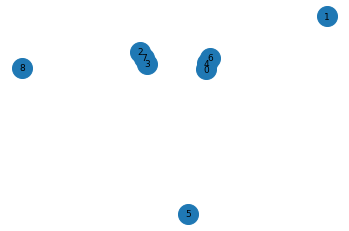

In [11]:
prim.draw_network()